# Author: Tobias

# Dataset Exploration

In [2]:
import os 
#make sure your working directory is the repository root. 
if not os.getcwd().endswith("idp-radio-1"):
    os.chdir("../../")
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math

In [3]:
load_dotenv(find_dotenv())

True

## Data Loading

In [6]:
dataset_folder = Path(os.environ.get('CHESTXRAY14_DATASET_DIRECTORY'))

train_labels = pd.read_csv(dataset_folder / 'meta/data/labels.csv')
train_labels["View Position"].replace({"PA": "frontal", "AP": "lateral"}).value_counts()

frontal    67310
lateral    44810
Name: View Position, dtype: int64

First, we have a simple look at the pictures in the dataset. There are two kinds of views, lateral
and frontal. 

### Shape of dataset

In [5]:
print('Shape of train data:', train_labels.shape)

Shape of train data: (112120, 28)


#### Patients

In [6]:
print('Number of unique patients:', train_labels['Patient ID'].unique().shape)
print('Avg. number of images per patient:',  train_labels.shape[0]  / train_labels['Patient ID'].unique().shape[0])

Number of unique patients: (30805,)
Avg. number of images per patient: 3.639668884921279


#### Studies per patient

In [7]:
counts = train_labels['Patient ID'].value_counts()
count_df = pd.DataFrame()
count_df['id'] = counts.index
count_df['count'] = counts.to_list()
print('Nr. of Studies | Patients')
print(count_df['count'].value_counts())

Nr. of Studies | Patients
1      17503
2       4113
3       2100
4       1330
5        938
       ...  
111        1
87         1
102        1
117        1
119        1
Name: count, Length: 103, dtype: int64


#### Frontal vs. Lateral

In [8]:
print('Number of Views images')
train_labels['View Position'].value_counts()

Number of Views images


PA    67310
AP    44810
Name: View Position, dtype: int64

## Labels

In [9]:
labels = train_labels.columns.to_list()[13:28]
print(labels)

['Edema', 'Atelectasis', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Infiltration', 'Consolidation', 'Fibrosis', 'No Finding', 'Effusion', 'Nodule', 'Mass', 'Hernia', 'Emphysema', 'Pneumothorax']


In [10]:
d = {'Pathology': [], 'Positive': [], 'Positive %': [], 'Negative': [], 'Negative %': [],}
for label in labels:
    values = train_labels.groupby(label)
    d['Pathology'].append(label)

    positive = values.size()[True]
    positive_percent = positive / train_labels.shape[0] * 100
    d['Positive'].append(positive)
    d['Positive %'].append(round(positive_percent))

    negative = values.size()[False]
    negative_percent = negative / train_labels.shape[0] * 100
    d['Negative'].append(negative)
    d['Negative %'].append(round(negative_percent))


In [11]:
df = pd.DataFrame(d)
df = df.set_index('Pathology')
df 

,Positive,Positive %,Negative,Negative %
Pathology,,,,
Edema,2303,2.0,109817,98.0
Atelectasis,11559,10.0,100561,90.0
Pneumonia,1431,1.0,110689,99.0
Pleural_Thickening,3385,3.0,108735,97.0
Cardiomegaly,2776,2.0,109344,98.0
Infiltration,19894,18.0,92226,82.0
Consolidation,4667,4.0,107453,96.0
Fibrosis,1686,2.0,110434,98.0
No Finding,60361,54.0,51759,46.0


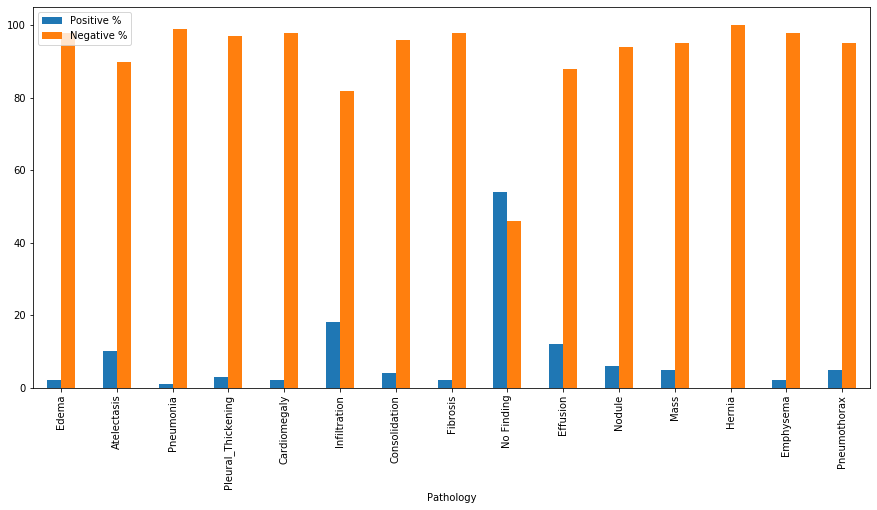

In [12]:
df[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(15,7))

## Images

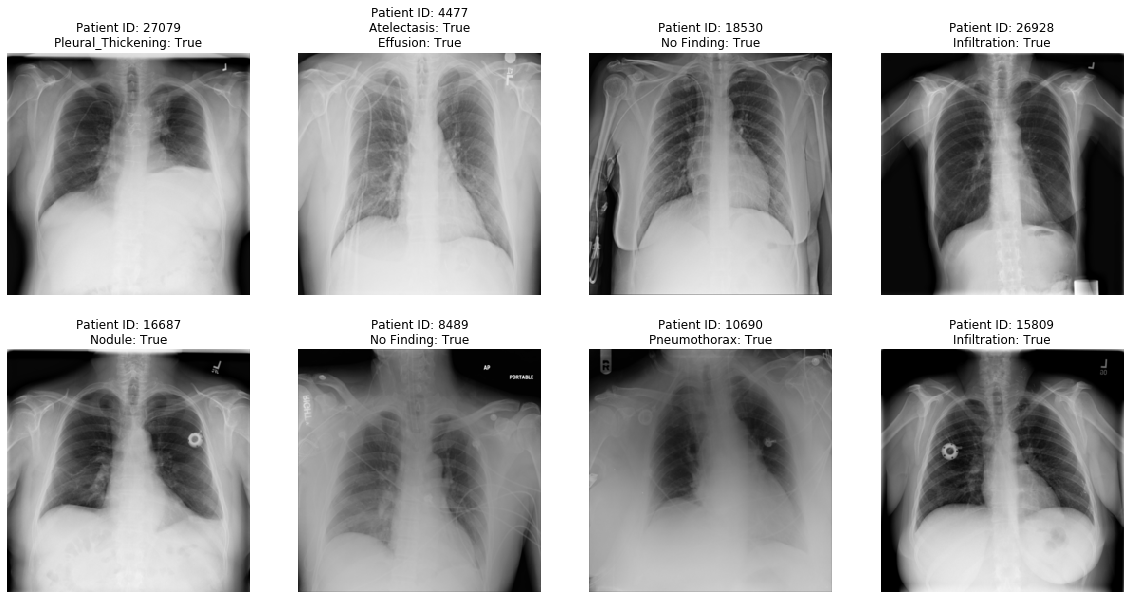

In [13]:
# Randomly sample 8 images
imgs_samples = train_labels.sample(n=8, random_state=1)

# Plot random sample of 8 images
plt.figure(figsize=(20, 10))
for i in range(len(imgs_samples)):
    img = cv2.imread(str(dataset_folder / "images" / imgs_samples['Image Index'].to_list()[i]))

    title = "Patient ID: " + str(imgs_samples['Patient ID'].to_list()[i])
    for label in labels:
        label_value = imgs_samples[label].to_list()[i]
        if label_value != False:
            title += '\n' + label + ': ' + str(imgs_samples[label].to_list()[i])
    # Plot the image
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
plt.show()


The pictures in the dataset are of varying size, so we take a look at the dimensions of the images. This information needs to be
considered when preprocessing the dataset.

In [14]:
# Prints all the different dimensions that images have
dimensions = []

for index, row in train_labels.iterrows():
    dimensions.append((row['OriginalImage_Width'], row['OriginalImage_Height']))

In [15]:
dimensions = pd.Series(dimensions)
dimensions.value_counts()

(2500, 2048)    37153
(2992, 2991)    21961
(3056, 2544)    15340
(2048, 2500)     8683
(2021, 2021)     4411
                ...  
(2960, 2399)        1
(2598, 2865)        1
(2730, 2789)        1
(2492, 2640)        1
(2638, 2828)        1
Length: 10471, dtype: int64